# Classify Fresh Fruits and Rotten Fruits

In [1]:
import pandas as pd

import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils.np_utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [3]:
from distutils.dir_util import copy_tree

train_folder = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train'
test_folder = '/kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test'

# Make a new train folder with fresh fruits
toDirectory = '/kaggle/working/train/freshfruits';

fromDirectory = train_folder + '/freshapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/freshbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/freshoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new train folder with rotten fruits
toDirectory = '/kaggle/working/train/rottenfruits';

fromDirectory = train_folder + '/rottenapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/rottenbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = train_folder + '/rottenoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new validation folder with fresh fruits
toDirectory = '/kaggle/working/validation/freshfruits';

fromDirectory = test_folder + '/freshapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/freshbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/freshoranges';
copy_tree(fromDirectory, toDirectory);

# Make a new validation folder with rotten fruits
toDirectory = '/kaggle/working/validation/rottenfruits';

fromDirectory = test_folder + '/rottenapples';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/rottenbanana';
copy_tree(fromDirectory, toDirectory);
fromDirectory = test_folder + '/rottenoranges';
copy_tree(fromDirectory, toDirectory);

Define a function to show an image and its size

In [4]:
def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

Let's take a look at what we are working with:

(382, 694, 3)


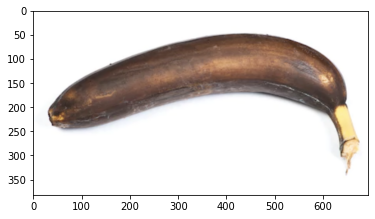

In [5]:
#Rotten example:
show_image('/kaggle/working/train/rottenfruits/vertical_flip_Screen Shot 2018-06-12 at 9.27.35 PM.png')

(254, 418, 3)


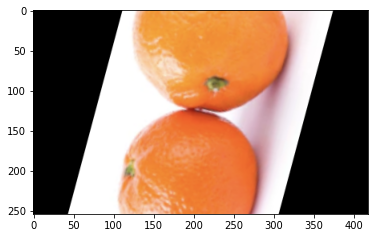

In [6]:
#Fresh Example:
show_image("/kaggle/working/train/freshfruits/rotated_by_75_Screen Shot 2018-06-13 at 12.15.21 AM.png")

In [7]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False);

58900480/58889256 [==============================] - 0s 0us/step


## Freeze Base Model

We freeze the model because we need to make changes to the model without losing the pre-trained results.

In [8]:
base_model.trainable = False

## Add Layers to Model

Now we add layers that are relevant to us:

1) **Input layer with size 224,224,3**

2) **Average pooling layer**

3) **One unit output layer** - we want to make a binary classification just a sigmoid basically.



In [9]:
# Create inputs with correct shape
inputs =  keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

# Add pooling layer
x = keras.layers.GlobalAveragePooling2D()(x)

# Add final dense layer
outputs = keras.layers.Dense(1,activation = 'sigmoid')(x)

# Combine inputs and outputs to create model
model = keras.Model(inputs, outputs)

Let's observe the summary of the model:

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


We can observe that our newly added layers "hugs" the model we already had.

## Compile Model

This is a binary (0 | 1) problem so we choose the *BinaryCrossentropy*.

More information: https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

In [12]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), metrics=[keras.metrics.BinaryAccuracy()])

## Augment the Data

To increase our collection of images we can use a generator.

The generator takes a picture we already have and "adjusts" it.

It might do a little tilt (or big one) and maybe zoom in, zoom out, flip it around.

It's the equivalent of opening a picture in an editor, rotating 5 degrees and saving as a picture with a different name.

This adds more **synthetic** data to our dataset, synthetic being made by us and not from the world.



In [13]:
datagen_train = ImageDataGenerator(
    samplewise_center=True,  # set each sample mean to 0
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontaly
    vertical_flip=True, # randomly flip images verticaly
)  

datagen_valid = ImageDataGenerator(samplewise_center=True)

We dont need to generate more validation data, we want more data while training, not while testing.

## Load Dataset

Instead of the 6 category fruits the data has, we want to turn it into 2 categories, rotten or fresh.

In [14]:
# load and iterate training dataset
train_it = datagen_train.flow_from_directory(
    '/kaggle/working/train/',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary"
)

# load and iterate validation dataset
valid_it = datagen_valid.flow_from_directory(
    '/kaggle/working/validation/',
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="binary"
)

Found 10901 images belonging to 2 classes.
Found 2698 images belonging to 2 classes.


## Train the Model

Now is the time to train the model.

We give it our training data made up of real world photos and synthetic generated ones to learn.

We provide the validating data because this training process already tests the model on its own, yey sceince!

Number of epochs was chosen based on trial and error, the least amount of epochs giving me acceptable results.

If you are not getting acceptable results, training with more epochs might help, but it's really the data sceintists job
to infer what might be the problem and how to handle/improve it.

In [15]:
model.fit(train_it,
          validation_data = valid_it,
          steps_per_epoch = train_it.samples/train_it.batch_size, # 340
          validation_steps = valid_it.samples/valid_it.batch_size, # 340
          epochs = 3)

Epoch 1/3
340/340 [==============================] - 162s 446ms/step - loss: 0.2825 - binary_accuracy: 0.8941 - val_loss: 0.1176 - val_binary_accuracy: 0.9581
Epoch 2/3
340/340 [==============================] - 148s 435ms/step - loss: 0.1050 - binary_accuracy: 0.9584 - val_loss: 0.0962 - val_binary_accuracy: 0.9663
Epoch 3/3
340/340 [==============================] - 147s 430ms/step - loss: 0.0815 - binary_accuracy: 0.9702 - val_loss: 0.0742 - val_binary_accuracy: 0.9766


## Evaluate the Model

Using keras built in method, we evaluate our model.

More info: https://www.tensorflow.org/api_docs/python/tf/keras/Model#evaluate

In [16]:
model.evaluate(valid_it, steps=valid_it.samples/valid_it.batch_size)

84/84 [==============================] - 11s 128ms/step - loss: 0.0742 - binary_accuracy: 0.9766


[0.07416324317455292, 0.9766493439674377]

Looks like we reached ~97% accuracy and ~8% loss.

## Testing the model

Let's define a function that will help us predict the results using our model:

In [17]:
def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

(290, 312, 3)


array([[0.01591968]], dtype=float32)

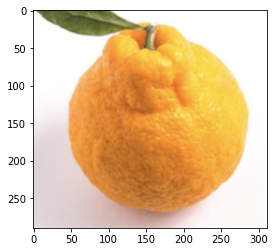

In [18]:
make_predictions('/kaggle/working/train/freshfruits/vertical_flip_Screen Shot 2018-06-13 at 12.18.07 AM.png')

(236, 300, 3)


array([[1.5736272e-05]], dtype=float32)

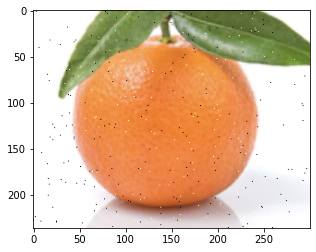

In [19]:
make_predictions('/kaggle/working/train/freshfruits/saltandpepper_Screen Shot 2018-06-12 at 11.58.11 PM.png')

(382, 622, 3)


array([[0.9999826]], dtype=float32)

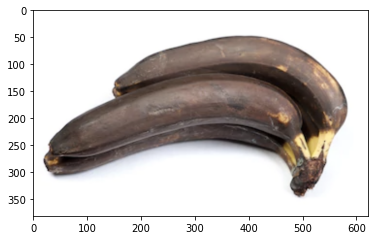

In [20]:
make_predictions('/kaggle/working/train/rottenfruits/vertical_flip_Screen Shot 2018-06-12 at 9.27.22 PM.png')

(312, 324, 3)


array([[0.999985]], dtype=float32)

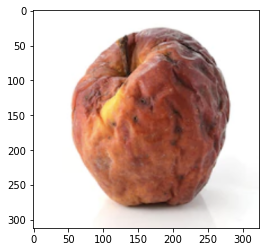

In [21]:
make_predictions('/kaggle/working/train/rottenfruits/vertical_flip_Screen Shot 2018-06-08 at 2.42.52 PM.png')

Because we used Sigmoid activation and judging from the results:

Prediction < 0.5 fresh else rotten

Lets write a helper function

In [23]:
def fresh_or_rotten(image_path):
    preds = make_predictions(image_path)
    if preds <= 0.5:
        print("It's Fresh! eat ahead.")
    else:
        print("It's Rotten, I wont recommend!")

One more test:

(316, 368, 4)
It's Rotten, I wont recommend!


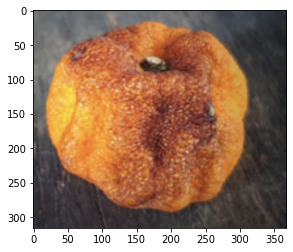

In [24]:
fresh_or_rotten('/kaggle/working/validation/rottenfruits/Screen Shot 2018-06-12 at 11.20.59 PM.png')

I have to admit, I've made a crime. 

I used images used in the model training and validation process and predicted them.

You should understand that because the model trained on these images it's as though it already knew the answer to the asked question before.

Just like you get to a job interview and asked a riddle, and you already knew the answer because you saw it before. 

To truly test the model, I took a picture of an orange I had, Lets test it out! 

(1033, 1727, 3)
It's Fresh! eat ahead.


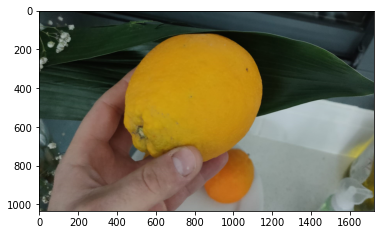

In [25]:
fresh_or_rotten('/kaggle/input/myfruitpictures/meHoldingFreshOrange.jpeg')

(1024, 1024, 3)
It's Rotten, I wont recommend!


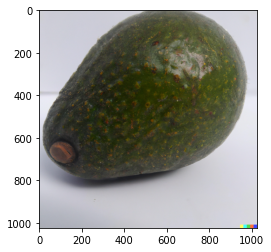

In [26]:
fresh_or_rotten('/kaggle/input/myfruitpictures/fresh_avocado_dalle.png')

Avocado is a bit tough on the model.

(1024, 1024, 3)
It's Fresh! eat ahead.


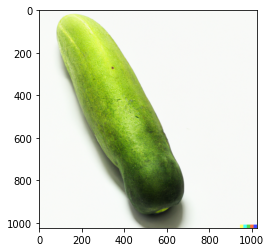

In [27]:
fresh_or_rotten('/kaggle/input/myfruitpictures/fresh_cucumber_dalle.png')

(1024, 1024, 3)
It's Fresh! eat ahead.


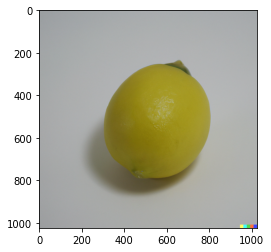

In [28]:
fresh_or_rotten('/kaggle/input/myfruitpictures/fresh_lemon_dalle.png')

(1024, 1024, 3)
It's Rotten, I wont recommend!


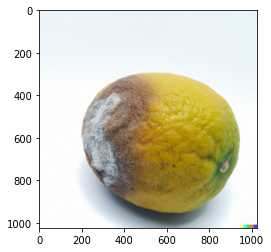

In [29]:
fresh_or_rotten('/kaggle/input/myfruitpictures/rotten_lemon_dalle.png')

(1024, 1024, 3)
It's Rotten, I wont recommend!


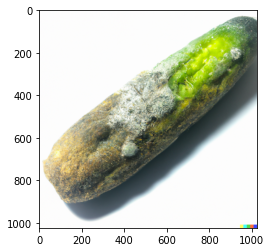

In [30]:
fresh_or_rotten('/kaggle/input/myfruitpictures/rotten_cucumber_dalle.png')

(1024, 1024, 3)
It's Rotten, I wont recommend!


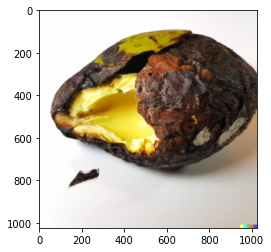

In [31]:
fresh_or_rotten('/kaggle/input/myfruitpictures/rotten_avocado_dalle.png')

As you can see the model could predict rotten or fresh on fruits it have never seen before, although with lower accuracy.

The model was trained using **only oranges, bananas and apples**.

All pictures except the one I'm holding an orange were generated using DALL-E2.

In [32]:
# Simpan model ke file .h5
model.save('/kaggle/working/fruit_classifier_model.h5')

print("Model telah disimpan dalam format .h5")


Model telah disimpan dalam format .h5


In [33]:
# Memuat model yang sudah disimpan
from tensorflow.keras.models import load_model

loaded_model = load_model('/kaggle/working/fruit_classifier_model.h5')

# Tampilkan ringkasan model untuk memastikan model telah dimuat
loaded_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________
